In [59]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [60]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from itertools import chain, combinations
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

In [61]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [62]:
plt.rc('font', family='NanumBarunGothic') #set font
plt.rc('axes', unicode_minus=False)

# Load

In [63]:
df = pd.read_csv('/content/gdrive/MyDrive/SolarPower/MappingDf.csv') #매핑만 된 데이터
df['월'] = pd.to_datetime(df['일자']).dt.month
print(df.shape)
df

(129664, 17)


,지역,시간,발전량,일자,기온,강수량,풍속,풍향,습도,해면기압,일조,일사,전운량,시정,PM10,PM25,월
0,전남 목포시,0,0.000,2013-01-01,-2.0,NaN,4.1,160.0,93.0,1021.4,NaN,NaN,3.0,2000.0,135.0,NaN,1
1,전남 목포시,1,0.000,2013-01-01,-2.2,NaN,3.7,160.0,95.0,1021.3,NaN,NaN,NaN,NaN,44.0,NaN,1
2,전남 목포시,2,0.000,2013-01-01,-2.4,NaN,3.6,160.0,95.0,1021.2,NaN,NaN,NaN,NaN,34.0,NaN,1
3,전남 목포시,3,0.000,2013-01-01,-2.7,NaN,3.6,160.0,95.0,1020.8,NaN,NaN,7.0,1800.0,41.0,NaN,1
4,전남 목포시,4,0.000,2013-01-01,-2.9,NaN,4.0,160.0,94.0,1020.0,NaN,NaN,7.0,1800.0,41.0,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129659,강원 강릉시,19,320.352,2020-12-31,-4.0,NaN,5.4,230.0,40.0,1020.0,NaN,NaN,0.0,4333.0,22.0,NaN,12
129660,강원 강릉시,20,342.336,2020-12-31,-4.3,NaN,6.4,230.0,41.0,1020.4,NaN,NaN,0.0,4853.0,24.0,NaN,12
129661,강원 강릉시,21,664.800,2020-12-31,-4.8,NaN,5.0,230.0,43.0,1021.3,NaN,NaN,0.0,3707.0,21.0,NaN,12
129662,강원 강릉시,22,692.736,2020-12-31,-4.9,NaN,5.3,230.0,42.0,1021.6,NaN,NaN,2.0,4694.0,32.0,NaN,12


In [64]:
df.isnull().sum()

지역           0
시간           0
발전량         18
일자           0
기온          48
강수량     117804
풍속          80
풍향         699
습도         496
해면기압       148
일조       58895
일사       58682
전운량      39188
시정        4378
PM10      9504
PM25     52199
월            0
dtype: int64

In [65]:
df.drop(columns='강수량', inplace=True) #대부분이 Null인 강수량 변수 삭제 
df.head(2)

,지역,시간,발전량,일자,기온,풍속,풍향,습도,해면기압,일조,일사,전운량,시정,PM10,PM25,월
0,전남 목포시,0,0.0,2013-01-01,-2.0,4.1,160.0,93.0,1021.4,NaN,NaN,3.0,2000.0,135.0,NaN,1
1,전남 목포시,1,0.0,2013-01-01,-2.2,3.7,160.0,95.0,1021.3,NaN,NaN,NaN,NaN,44.0,NaN,1


In [41]:
Gn_df = df[df['지역'] == '강원 강릉시']
Gn_df.reset_index(drop=True, inplace=True)
print(Gn_df.shape)
Gn_df.head()

(35063, 16)


,지역,시간,발전량,일자,기온,풍속,풍향,습도,해면기압,일조,일사,전운량,시정,PM10,PM25,월
0,강원 강릉시,0,0.0,2017-01-01,4.3,4.1,290.0,45.0,1026.8,NaN,NaN,NaN,3870.0,58.0,46.0,1
1,강원 강릉시,1,0.0,2017-01-01,4.3,5.1,290.0,46.0,1027.2,NaN,NaN,NaN,3874.0,63.0,51.0,1
2,강원 강릉시,2,0.0,2017-01-01,4.4,4.4,290.0,44.0,1027.0,NaN,NaN,NaN,4019.0,63.0,57.0,1
3,강원 강릉시,3,0.0,2017-01-01,4.3,3.5,320.0,44.0,1027.1,NaN,NaN,NaN,4802.0,64.0,49.0,1
4,강원 강릉시,4,0.0,2017-01-01,4.2,3.4,320.0,44.0,1026.8,NaN,NaN,NaN,3755.0,61.0,50.0,1


In [42]:
area_name = ['Gn', 'Jj', 'Mp' ]
for idx, area in enumerate(['강원 강릉시','경남 진주시', '전남 목포시']):
  name = area_name[idx]
  data = df[df['지역'] == area]
  data.reset_index(drop=True, inplace=True)
  globals()[f'{name}_df'] = data

  
print(f'목포시 : {Mp_df.shape}\n진주시 : {Jj_df.shape}\n강릉시 : {Gn_df.shape}')

목포시 : (61343, 16)
진주시 : (33258, 16)
강릉시 : (35063, 16)


# Seasonal split

In [43]:
def monthly_plot(df, col, name):
  data = pd.DataFrame()
  day_list = df['일자'].unique()
  
  for day in day_list:
    data_sum = df[df['일자'] == day][col].mean()
    sum_df = pd.DataFrame([[day, data_sum]], columns=['일자',f'{col}합계'])
    data = pd.concat([data, sum_df]).reset_index(drop=True)

  data['월'] = data['일자'].str[5:7]
  data['월'] = data['월'].astype(int)

  #월별 sum 자료
  for i in range(1,13):
    date = datetime(year = 2013, month = i, day = 1)
    month = date.strftime('%b')
    globals()[month] = data[data['월'].isin([i])][f'{col}합계'].to_numpy(int)

  fig, ax = plt.subplots(1, 1, figsize=(10, 5), constrained_layout=True)
  m_list = np.array([Jan, Feb, Mar, Apr, May, Jun, Jul, Aug, Sep, Oct, Nov, Dec], dtype=object)

  ax.boxplot(m_list, showmeans=True)
  ax.set_xticks(range(1,13))
  ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], fontsize=16)
  ax.set_title(f"Average {name}", loc='center', fontsize=20, pad=15)
  ax.set_xlabel('month', fontsize=16)
  ax.set_ylabel(f'AVG {col}', fontsize=13)
  plt.show()

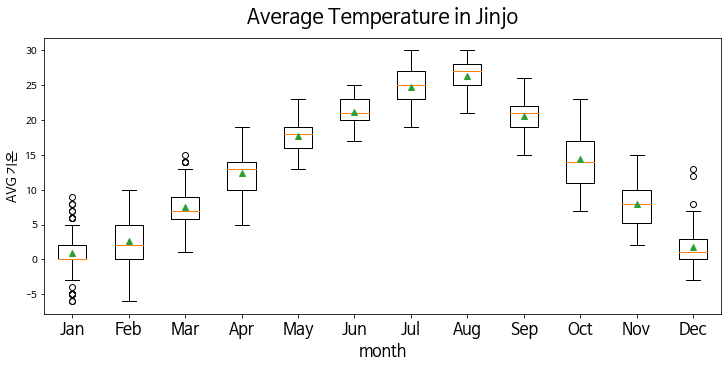

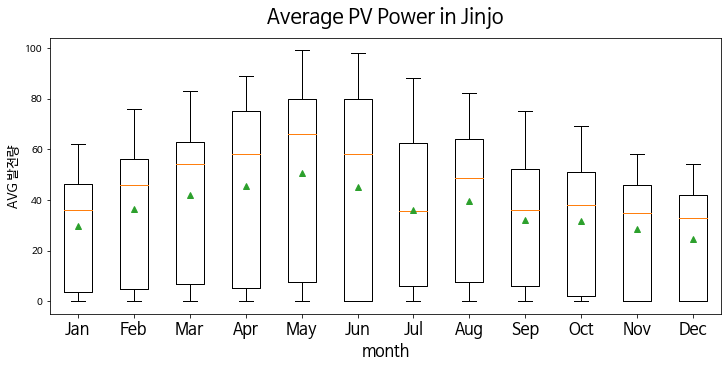

In [44]:
monthly_plot(Jj_df, '기온', 'Temperature in Jinjo')
monthly_plot(Jj_df,'발전량', 'PV Power in Jinjo')

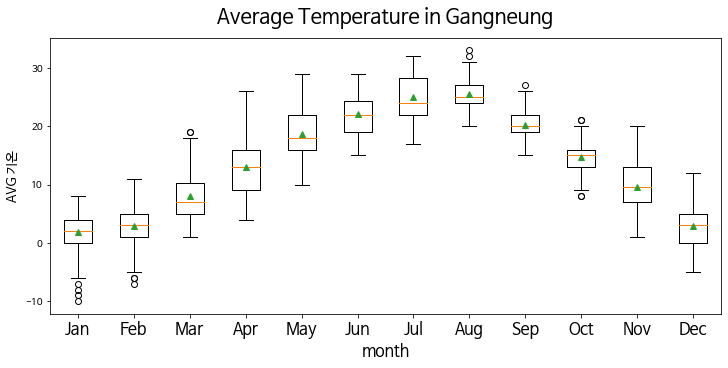

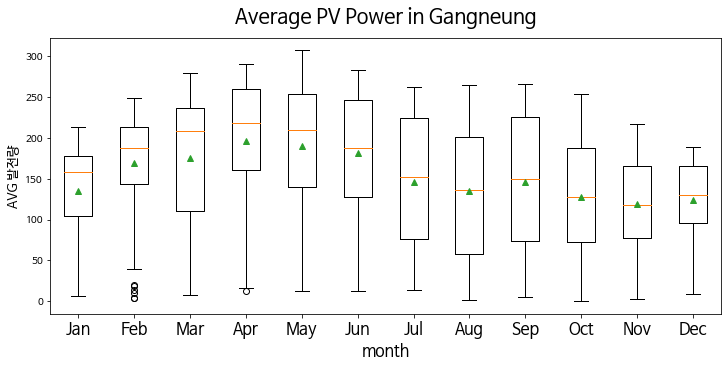

In [45]:
monthly_plot(Gn_df, '기온', 'Temperature in Gangneung')
monthly_plot(Gn_df,'발전량', 'PV Power in Gangneung')

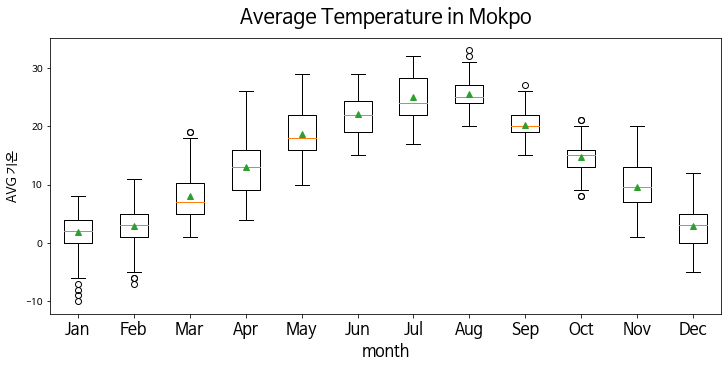

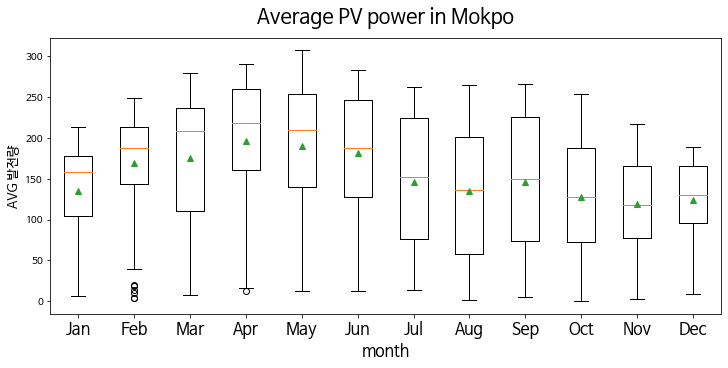

In [46]:
monthly_plot(Gn_df, '기온', 'Temperature in Mokpo')
monthly_plot(Gn_df,'발전량', 'PV power in Mokpo')

In [47]:
def SeasonSplit(df): 
  hot_season = pd.DataFrame()
  cold_season = pd.DataFrame()
  for i in range(5,11): #기온이 높은 5~11월
    idx = df[df['월'] == i].index
    data = df.loc[idx]
    hot_season = pd.concat([hot_season,data])
  for i in [1,2,3,4,11,12]: #나머지 계절로 분리
    idx = df[df['월'] == i].index
    data = df.loc[idx]
    cold_season = pd.concat([cold_season,data])
  hot_season.reset_index(drop=True, inplace=True)
  cold_season.reset_index(drop=True, inplace=True)
  return hot_season, cold_season

# Correlation analysis

## Area

In [48]:
def correlation(df, cols, name):
  fig, ax = plt.subplots(figsize=(15,6))
  plt.title(f'{name} correlation', fontsize=15)
  
  data = df.copy()
  data = data[cols]

  corr_df = data.corr()
  mask = np.zeros_like(corr_df, dtype=bool)
  mask[np.triu_indices_from(mask)] = True

  sns.heatmap(corr_df, 
            cmap = 'RdBu_r', 
            annot = True,   
            mask = mask,
            linewidths = .5,
            cbar_kws = {"shrink": .8}, 
            vmin = -1,
            vmax = 1
             )  
  plt.show()
  return corr_df

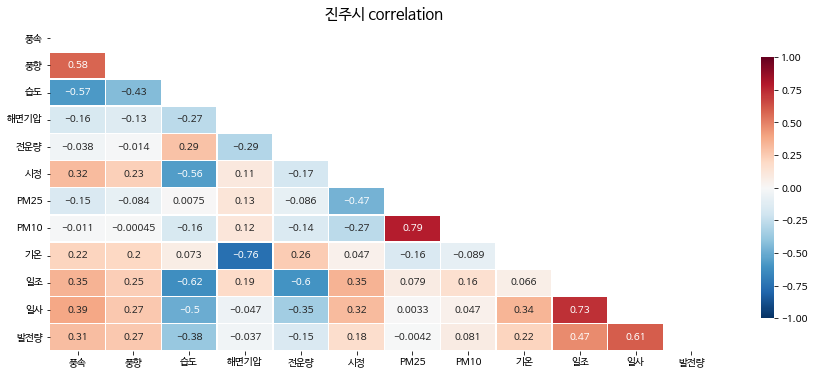

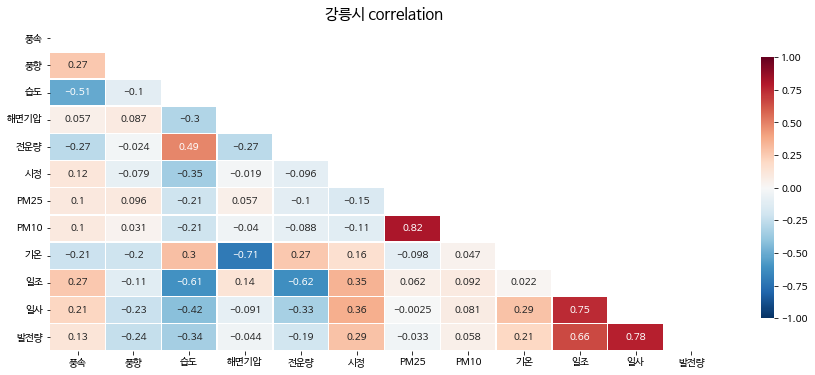

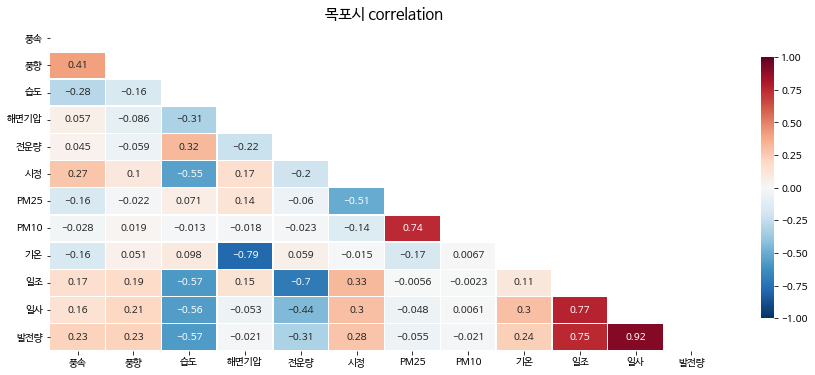

In [49]:
cols = ['풍속', '풍향', '습도', '해면기압', '전운량', '시정','PM25', 'PM10','기온', '일조','일사', '발전량']
corr_Jj = correlation(Jj_df, cols, '진주시')
corr_Gn = correlation(Gn_df, cols, '강릉시')
corr_Mp = correlation(Mp_df, cols, '목포시')

In [50]:
def CorrBar(df, cols, area):
  #중복 제거한 변수 조합으로 상관관계 데이터 만들기
  Sublist = chain.from_iterable(combinations(cols,n) for n in range(2,3))
  data = pd.DataFrame(columns=["cols",'corr'])
  for c in Sublist:
    corr_num = df.loc[c]
    add_df = pd.DataFrame([[c, corr_num]] , columns=["cols",'corr'])
    data = pd.concat([data, add_df])
  data.sort_values('corr', ascending=False, inplace=True)
  data.reset_index(inplace=True, drop=True)

  #상관계수 양,음수로 데이터 분리(0.1보다 작은 상관관계는 제외)
  pos_df = data[data['corr'] >= 0.1] 
  neg_df = data[data['corr'] < -0.1]

  #양,음 데이터로 각각 그래프 그리기
  fig, [ax1, ax2] = plt.subplots(figsize=(18,10), nrows=2, ncols=1)
  # sns.color_palette('blues', len(pos_df))
  bar1 = ax1.bar(range(0, len(pos_df)), pos_df['corr'], color=sns.color_palette('Reds_r', len(pos_df)))
  bar2 = ax2.bar(range(0, len(neg_df)), -neg_df['corr'], color=sns.color_palette('Blues', len(neg_df)))
  plt.suptitle(f'negative and positive correlation in {area}', fontsize=30)
  ax1.set_xticks(range(0, len(pos_df)))
  ax2.set_xticks(range(0, len(neg_df)))
  ax1.set_xticklabels([i for i in pos_df['cols'].str[0]], fontsize=14, rotation=-40)
  ax2.set_xticklabels([i for i in neg_df['cols'].str[0]], fontsize=14, rotation=-40)

  #라벨을 넣어줘서 연관관계 변수 표시 
  po_label = [i for i in pos_df['cols'].str[1]]
  ne_label = [i for i in neg_df['cols'].str[1]]
  for bar in [bar1,bar2]:
    if bar == bar1:
      label = po_label
      ax = ax1
    else:
      label = ne_label
      ax = ax2
    idx=0  
    for b in bar:
      x = b.get_x()
      y = b.get_height()
      ax.text(x , y, label[idx], va = 'bottom', fontsize=13)
      idx+=1
  plt.show()
  return data

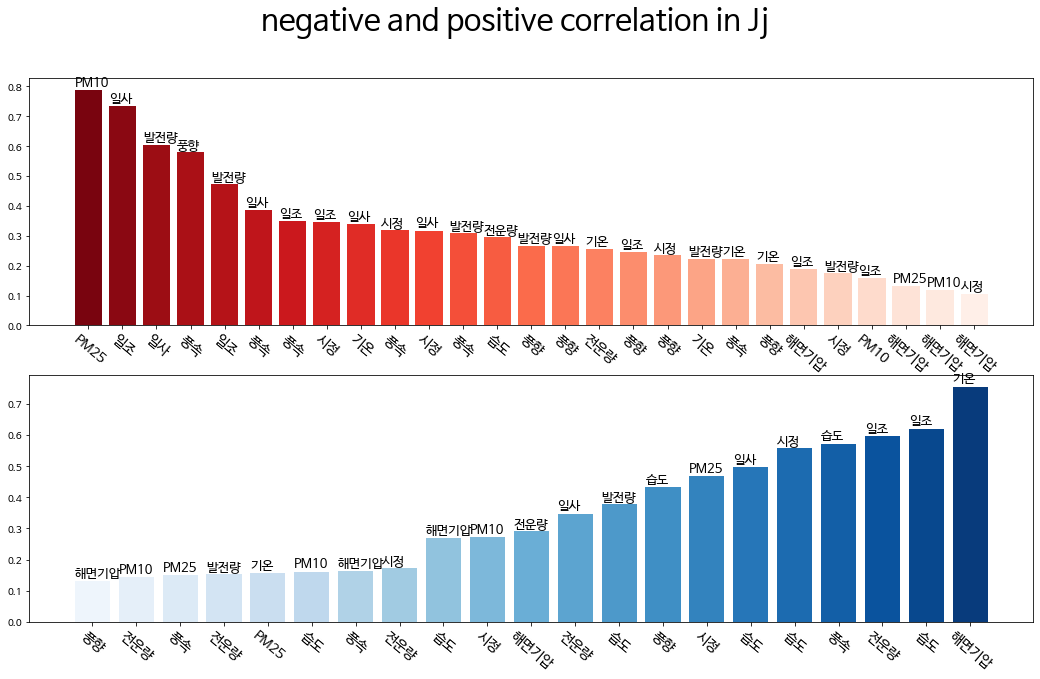

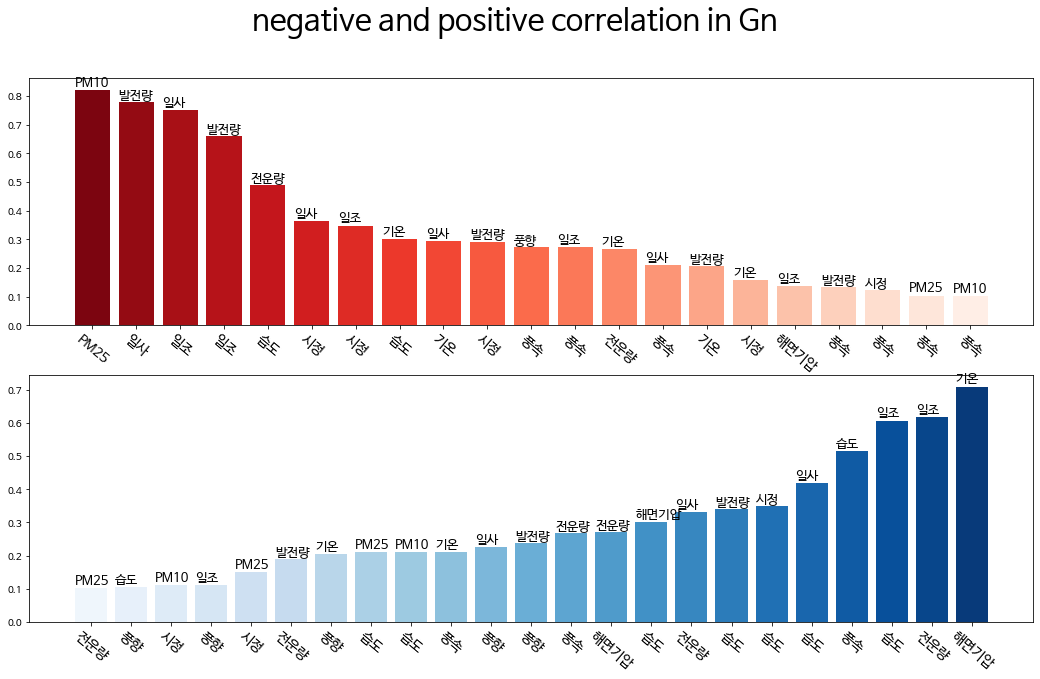

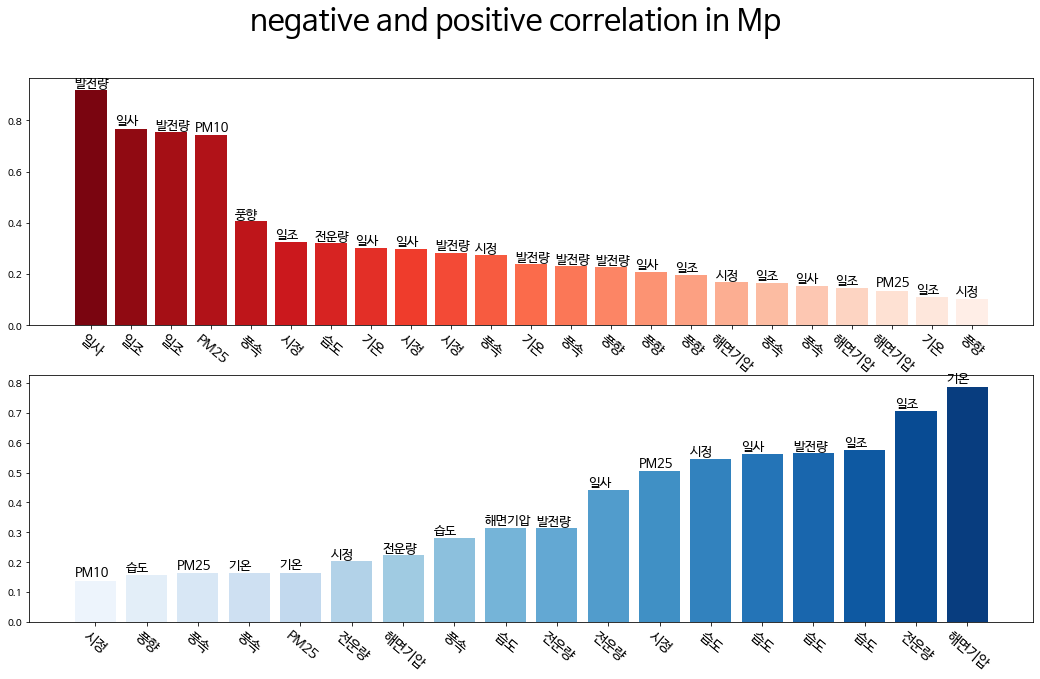

In [51]:
Jj_data = CorrBar(corr_Jj, cols, 'Jj')
Gn_data = CorrBar(corr_Gn, cols, 'Gn')
Mp_data = CorrBar(corr_Mp, cols, 'Mp')

In [52]:
Jj_data['지역'] = '진주'
Gn_data['지역'] = '강릉'
Mp_data['지역'] = '목포'
corr_data = pd.concat([Jj_data,Mp_data,Gn_data], axis=1)
corr_data

,cols,corr,지역,cols,corr,지역,cols,corr,지역
0,"(PM25, PM10)",0.787854,진주,"(일사, 발전량)",0.917555,목포,"(PM25, PM10)",0.819937,강릉
1,"(일조, 일사)",0.733836,진주,"(일조, 일사)",0.767760,목포,"(일사, 발전량)",0.777456,강릉
2,"(일사, 발전량)",0.605325,진주,"(일조, 발전량)",0.753683,목포,"(일조, 일사)",0.748925,강릉
3,"(풍속, 풍향)",0.581168,진주,"(PM25, PM10)",0.742622,목포,"(일조, 발전량)",0.659619,강릉
4,"(일조, 발전량)",0.473017,진주,"(풍속, 풍향)",0.406765,목포,"(습도, 전운량)",0.487744,강릉
...,...,...,...,...,...,...,...,...,...
61,"(습도, 시정)",-0.558763,진주,"(습도, 일사)",-0.561120,목포,"(습도, 일사)",-0.419236,강릉
62,"(풍속, 습도)",-0.572410,진주,"(습도, 발전량)",-0.565643,목포,"(풍속, 습도)",-0.514536,강릉
63,"(전운량, 일조)",-0.596848,진주,"(습도, 일조)",-0.573931,목포,"(습도, 일조)",-0.607344,강릉
64,"(습도, 일조)",-0.620692,진주,"(전운량, 일조)",-0.704434,목포,"(전운량, 일조)",-0.618054,강릉


## Season

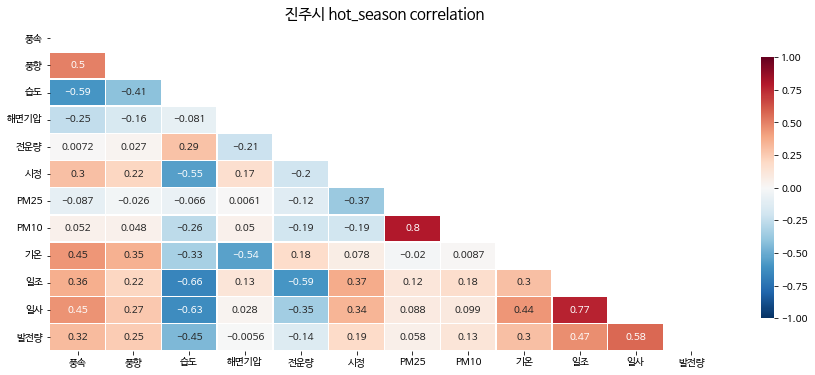

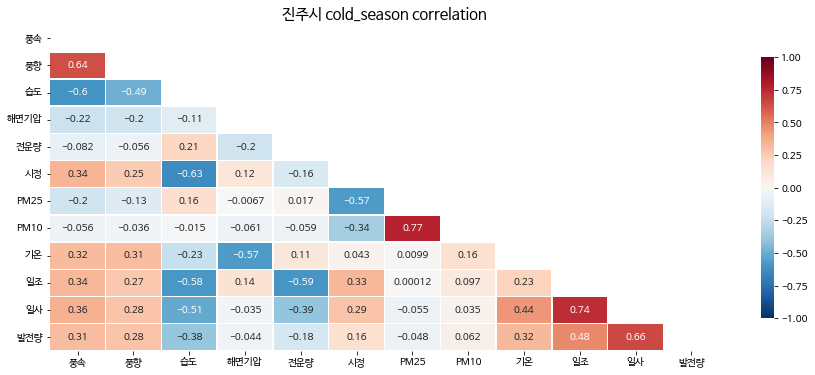

In [53]:
cols =['풍속', '풍향', '습도', '해면기압', '전운량', '시정','PM25', 'PM10','기온', '일조','일사', '발전량']
hot_season, cold_season = SeasonSplit(Jj_df)
h = correlation(hot_season, cols, '진주시 hot_season')
c = correlation(cold_season, cols, '진주시 cold_season')

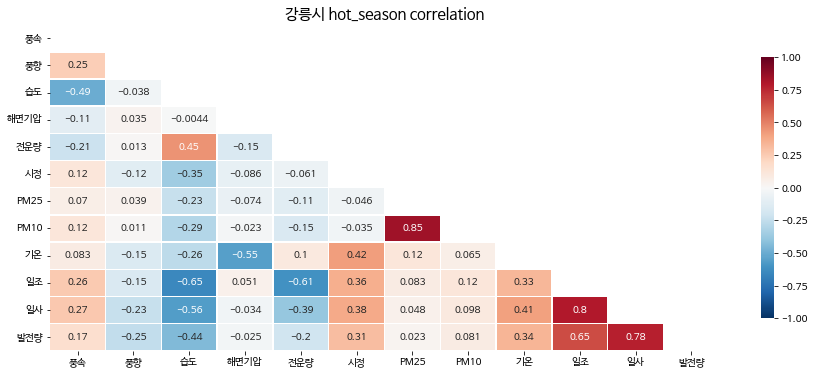

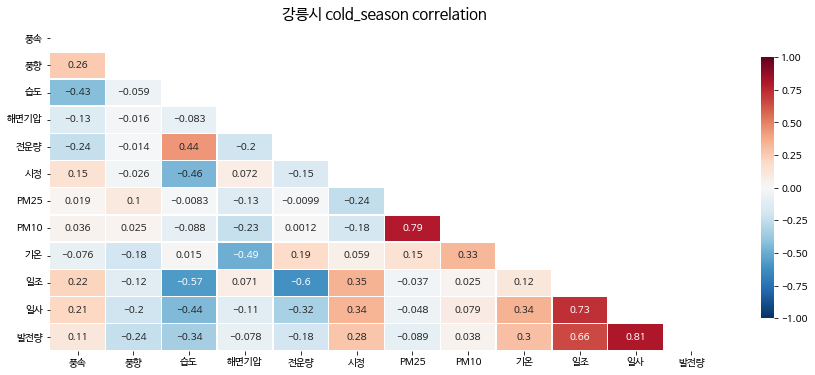

In [54]:
hot_season, cold_season = SeasonSplit(Gn_df)
h = correlation(hot_season, cols, '강릉시 hot_season')
c = correlation(cold_season, cols, '강릉시 cold_season')

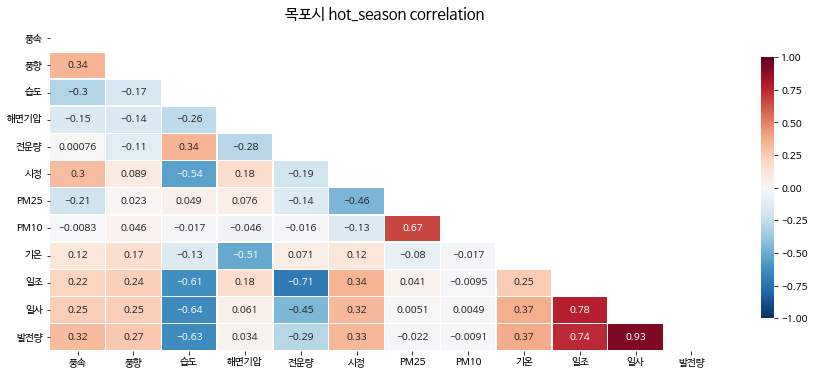

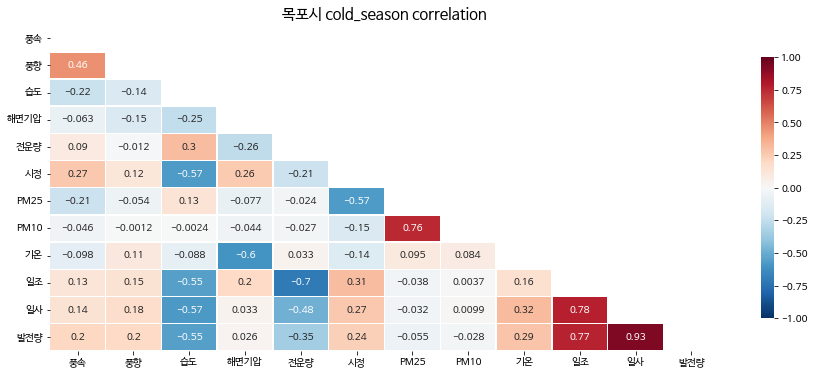

In [55]:
hot_season, cold_season = SeasonSplit(Mp_df)
h = correlation(hot_season, cols, '목포시 hot_season')
c = correlation(cold_season, cols, '목포시 cold_season')

# Save data

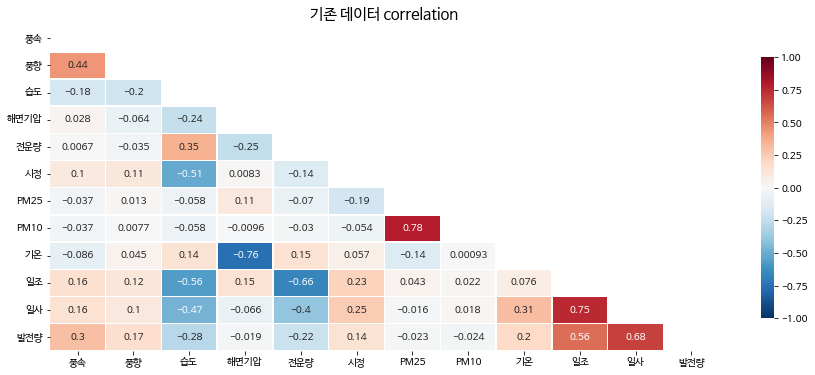

In [66]:
c = correlation(df, cols, '기존 데이터')

In [67]:
df.drop(columns =['일조','PM25'], inplace=True) #상관관계가 높은 일조-일사 , PM25-PM10 변수들 중 하나씩 제거 
df.head(3)

,지역,시간,발전량,일자,기온,풍속,풍향,습도,해면기압,일사,전운량,시정,PM10,월
0,전남 목포시,0,0.0,2013-01-01,-2.0,4.1,160.0,93.0,1021.4,NaN,3.0,2000.0,135.0,1
1,전남 목포시,1,0.0,2013-01-01,-2.2,3.7,160.0,95.0,1021.3,NaN,NaN,NaN,44.0,1
2,전남 목포시,2,0.0,2013-01-01,-2.4,3.6,160.0,95.0,1021.2,NaN,NaN,NaN,34.0,1


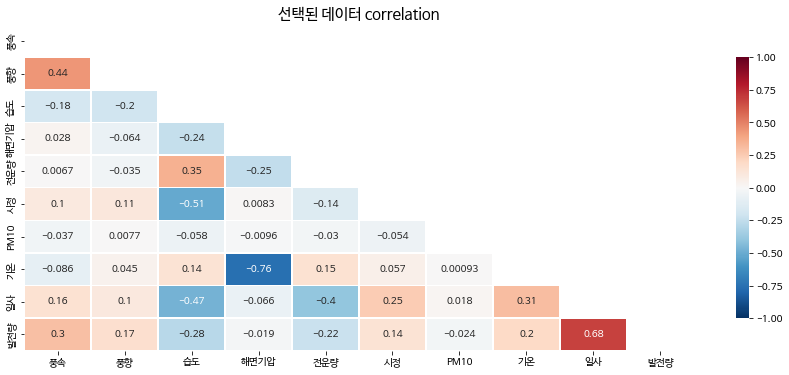

In [71]:
cols.remove('일조')
cols.remove('PM25')
c = correlation(df, cols, '선택된 데이터')

In [72]:
df.to_csv('/content/gdrive/MyDrive/SolarPower/DropColsData.csv', index=None) #상관관계가 높은 변수 일부 제거한 데이터